# Zonal statistics for a single catchment (German data example)

Author: [Irene Crisologo](http://philippineradarnetwork.wordpress.com)

This notebook demonstrates the use of the zonal statistics module to extract information such as mean, max, and variance rainfall within a single catchment. 

The data used here is from Germany, with the precipitation data from the [German Weather Service (DWD)](dwd.de) and the shapefiles from [GADM](http://www.gadm.org/).

Import necessary modules.

In [1]:
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np

from osgeo import osr

#### Reading the shapefiles and the radar data

In [2]:
# Open shapefile (shapefile is in WGS84)
dataset_DE, inLayer_DE = wrl.io.open_shape('../phirad-data/shapefiles/Germany/DEU_adm/DEU_adm0.shp')
borders_DE, keys_DE = wrl.georef.get_shape_coordinates(inLayer_DE)

# Open shapefile (shapefile is in GK2)
dataset, inLayer = wrl.io.open_shape('../phirad-data/shapefiles/Germany/Elbe/elbe_subcatchment_1.shp')
borders, keys = wrl.georef.get_shape_coordinates(inLayer)

In [3]:
# Read and prepare the actual data (RADOLAN)
f = wrl.util.get_wradlib_data_file(
    'radolan/showcase/raa01-ry_10000-1408102050-dwd---bin.gz')
data, attrs = wrl.io.read_RADOLAN_composite(f, missing=np.nan)
sec = attrs['secondary']
data.flat[sec] = np.nan

#### Setting up the RADOLAN grid coordinates and the different projection osr objects

`wrl.georef.get_radolan_grid()` has a keyword argument `wgs84` that can be set to `True`. For the purpose of this notebook, which is to do some zonal statistics computations, it has to remain as `False`, which is the default. The projection is transformed later for plotting.

In [4]:
# Get RADOLAN grid coordinates
grid_xy_radolan = wrl.georef.get_radolan_grid(900, 900)
x_radolan = grid_xy_radolan[:, :, 0]
y_radolan = grid_xy_radolan[:, :, 1]

In [5]:
# create radolan projection osr object
proj_stereo = wrl.georef.create_osr("dwd-radolan")

# create Gauss Krueger zone 3 projection osr object
proj_gk = osr.SpatialReference()
proj_gk.ImportFromEPSG(31466)

# create WGS84 projection osr object (for plotting purposes)
proj_wgs84 = osr.SpatialReference()
proj_wgs84.ImportFromEPSG(4326)

# transform radolan polar stereographic projection to GK2
xy = wrl.georef.reproject(grid_xy_radolan,
                          projection_source=proj_stereo,
                          projection_target=proj_gk)

#### Plotting the data

Here we plot the data together with the shapefiles to have an overview.

(46.95258041119029, 54.732706795258061)

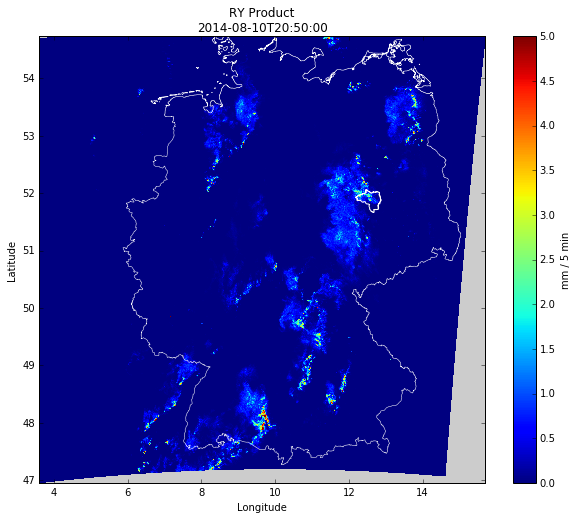

In [6]:
# plot with shapefiles

# transform radolan grid to WGS84
grid_xy_radolan_wgs84 = wrl.georef.reproject(grid_xy_radolan,
                          projection_source=proj_stereo,
                          projection_target=proj_wgs84) 

# transform catchment shapefile to WGS84
borders_wgs84 = wrl.georef.reproject(borders,
                          projection_source=proj_gk,
                          projection_target=proj_wgs84)  

# plot
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor((0.8,0.8,0.8))
x = grid_xy_radolan_wgs84[:,:,0]
y = grid_xy_radolan_wgs84[:,:,1]
pm = ax.pcolormesh(x, y, data, cmap='jet', vmax=5, vmin=0)
wrl.vis.add_lines(ax, borders_wgs84, color='white', lw=1)
wrl.vis.add_lines(ax, borders_DE, color='white', lw=0.5)
cb = fig.colorbar(pm)
cb.set_label('mm / 5 min')
pl.xlabel("Longitude")
pl.ylabel("Latitude")
pl.title('{0} Product\n{1}'.format(attrs['producttype'],
                                   attrs['datetime'].isoformat()))
pl.xlim((x[0,0],x[-1,-1]))
pl.ylim((y[0,0],y[-1,-1]))

Zooming in by changing the plot extents (`xlim` and `ylim`):

(51.5, 52.3)

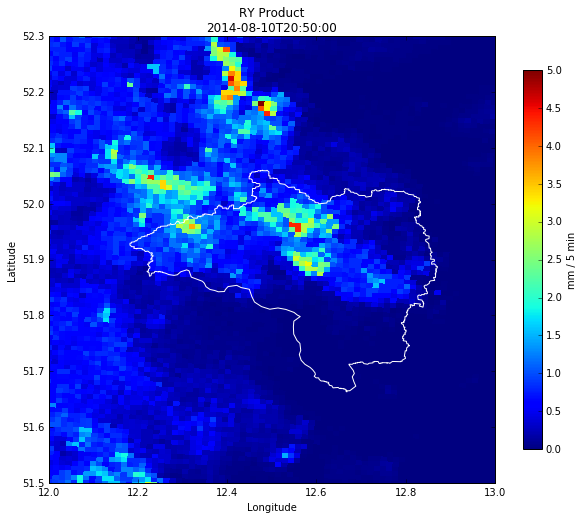

In [7]:
# plot with shapefiles
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor((0.8,0.8,0.8))
x = grid_xy_radolan_wgs84[:,:,0]
y = grid_xy_radolan_wgs84[:,:,1]
pm = ax.pcolormesh(x, y, data, cmap='jet', vmax=5, vmin=0)
wrl.vis.add_lines(ax, borders_wgs84, color='white', lw=1)
cb = fig.colorbar(pm, shrink=0.85)
cb.set_label('mm / 5 min')
pl.xlabel("Longitude")
pl.ylabel("Latitude")
pl.title('{0} Product\n{1}'.format(attrs['producttype'],
                                   attrs['datetime'].isoformat()))
pl.xlim((12,13))
pl.ylim((51.5,52.3))

#### Zonal statistics

Here we want to determine the average amount of rainfall that fell within the catchment within 5 mins (temporal resolution of data).
First we get the bounding box and limit the data to that bounding box so make the computation faster.

In [8]:
# Reduce grid size using a bounding box (to enhance performance)
bbox = inLayer.GetExtent()
buffer = 5000
bbox = dict(left=bbox[0] - buffer, right=bbox[1] + buffer,
            bottom=bbox[2] - buffer, top=bbox[3] + buffer)
mask, shape = wrl.zonalstats.mask_from_bbox(xy[..., 0], xy[..., 1],
                                                bbox)
xy_ = np.vstack((xy[..., 0][mask].ravel(), xy[..., 1][mask].ravel())).T  

# mask the data
data_ = data[mask]

In [9]:
# Create vertices for each grid cell
# (MUST BE DONE IN NATIVE RADOLAN COORDINATES)
grdverts = wrl.zonalstats.grid_centers_to_vertices(x_radolan[mask],
                                                   y_radolan[mask], 1.,
                                                   1.)
# And reproject to Cartesian reference system (here: GK2)
grdverts = wrl.georef.reproject(grdverts,
                                projection_source=proj_stereo,
                                projection_target=proj_gk)  

In [10]:
# Create instance of type ZonalDataPoly from source grid and
# catchment array
zd = wrl.zonalstats.ZonalDataPoly(grdverts, [borders], srs=proj_gk)
# Create instance of type GridPointsToPoly from zonal data object
obj = wrl.zonalstats.GridCellsToPoly(zd)

Calculate Intersection source/target-layers


Compute the average, variance, and maximum precipitation value for the catchment.

In [11]:
# Compute stats for target polygons
avg = obj.mean(data_.ravel())
var = obj.var(data_.ravel())
maxp = np.max(data_[obj._ix[0]])

In [12]:
print "Average precipitation: %s" %avg[0]
print "Variance: %s" %var[0]
print "Maximum precipitation: %s" %maxp

Average precipitation: 0.600504112546
Variance: 0.436131467659
Maximum precipitation: 4.34
